In [663]:
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
%matplotlib inline

# Pseudocode and Goals of Bandit Algorithms

```
GOALS:
input - the arm chosen by the player
objective - to maximize reward which is determined by minimizing regret
constraints - 
model - varies

EPSILON GREEDY
for t = 1...numTurns:
  flip a coin with probability epsilon of heads and 1 - epsilon of tails
  if heads:
    pull a random arm
  else:
    calculate the arm with the best experimental mean
    pull the arm with the best experimental mean

UCB
first k turns: initialize experimental means by pulling each arm once
for t = k+1...numTurns:
  for i = 1...k:
    calculate a(i, t) = 2 * log(t / p(i, t))
  pull arm i that maximizes experimental mean + a(i, t)

```



In [664]:
# Function that graphs the average reward of an algorithm over time
# Also graphs a barchart to show the frequency at which particular arms are chosen

def plot_history(history):
    rewards = history["rewards"]
    average_rewards = history["average_rewards"]
    chosen_arms = history["arms"]
    cumulative_rewards = history["cumulative_rewards"]

#     fig = plt.figure(figsize=[30, 90])
    fig, axs = plt.subplots(3, figsize=[30, 30])
    
#     ax1 = fig.add_subplot(321)
#     ax1 = plt.subplot()
    axs[0].plot(cumulative_rewards, label = "cumulative rewards")
    axs[0].set_title("Rewards")
    axs[0].set_xlabel("Iteration")
    axs[0].set_ylabel("Rewards")
    
#     ax2 = fig.add_subplot(322)
#     ax2 = plt.subplot()
    axs[1].plot(average_rewards, label = "average rewards")
    axs[1].set_title("Average Rewards")
    axs[1].set_xlabel("Iteration")
    axs[1].set_ylabel("Reward")
    
#     ax3 = fig.add_subplot(311)
#     ax3 = plt.subplot()
    axs[2].bar([i for i in range(len(chosen_arms))], chosen_arms, label = "chosen arms")
    axs[2].set_title("Chosen Actions")
    axs[2].set_xlabel("Arm #")
    axs[2].set_ylabel("Number of times selected")  

In [665]:
class Env():
    def __init__(self, rewards, deviations):
        self.rewards = rewards
        self.deviations = deviations
        self.k = len(rewards)

    def choose_arm(self, arm):
        return np.random.normal(self.rewards[arm], self.deviations[arm])

In [666]:
nArms = 5000
# r = [1, 2, 3, 4, 5]
# d = [1, 1, 1, 1, 0]
# environment = Env(rewards=r, deviations=d)

environment = Env(rewards=np.random.randint(1, 50, nArms), deviations=np.random.randint(1, 25, nArms))

# x = np.random.randint(1, 100, 20)
# y = np.random.randint(1, 10, 20)
# environment2 = Env(rewards=x, deviations=y)
# for i in range(len(x)):
#     print(x[i], y[i])
#     print(environment2.choose_arm(i))

# Random Agent

In [667]:
# This agent simply chooses random arm
class RandomAgent():
    def __init__(self, env, max_iterations=2000):
        self.env = env
        self.iterations = max_iterations

    def act(self):
        arm_counts = np.zeros(self.env.k)
        rewards = []
        average_rewards = []
        cumulative_rewards = []

        for i in range(1, self.iterations + 1):
            arm = np.random.choice(self.env.k)
            reward = self.env.choose_arm(arm)

            arm_counts[arm] += 1
            rewards.append(reward)
            cumulative_rewards.append(sum(rewards))
            average_rewards.append(sum(rewards) / len(rewards))

        return {"arms" : arm_counts, "rewards": rewards, "average_rewards": average_rewards,
                "cumulative_rewards": cumulative_rewards}

In [668]:
random_agent = RandomAgent(env=environment, max_iterations=2000)
RA_history = random_agent.act()
print(f"TOTAL REWARD : {sum(RA_history['rewards'])}")

TOTAL REWARD : 50818.773799448274


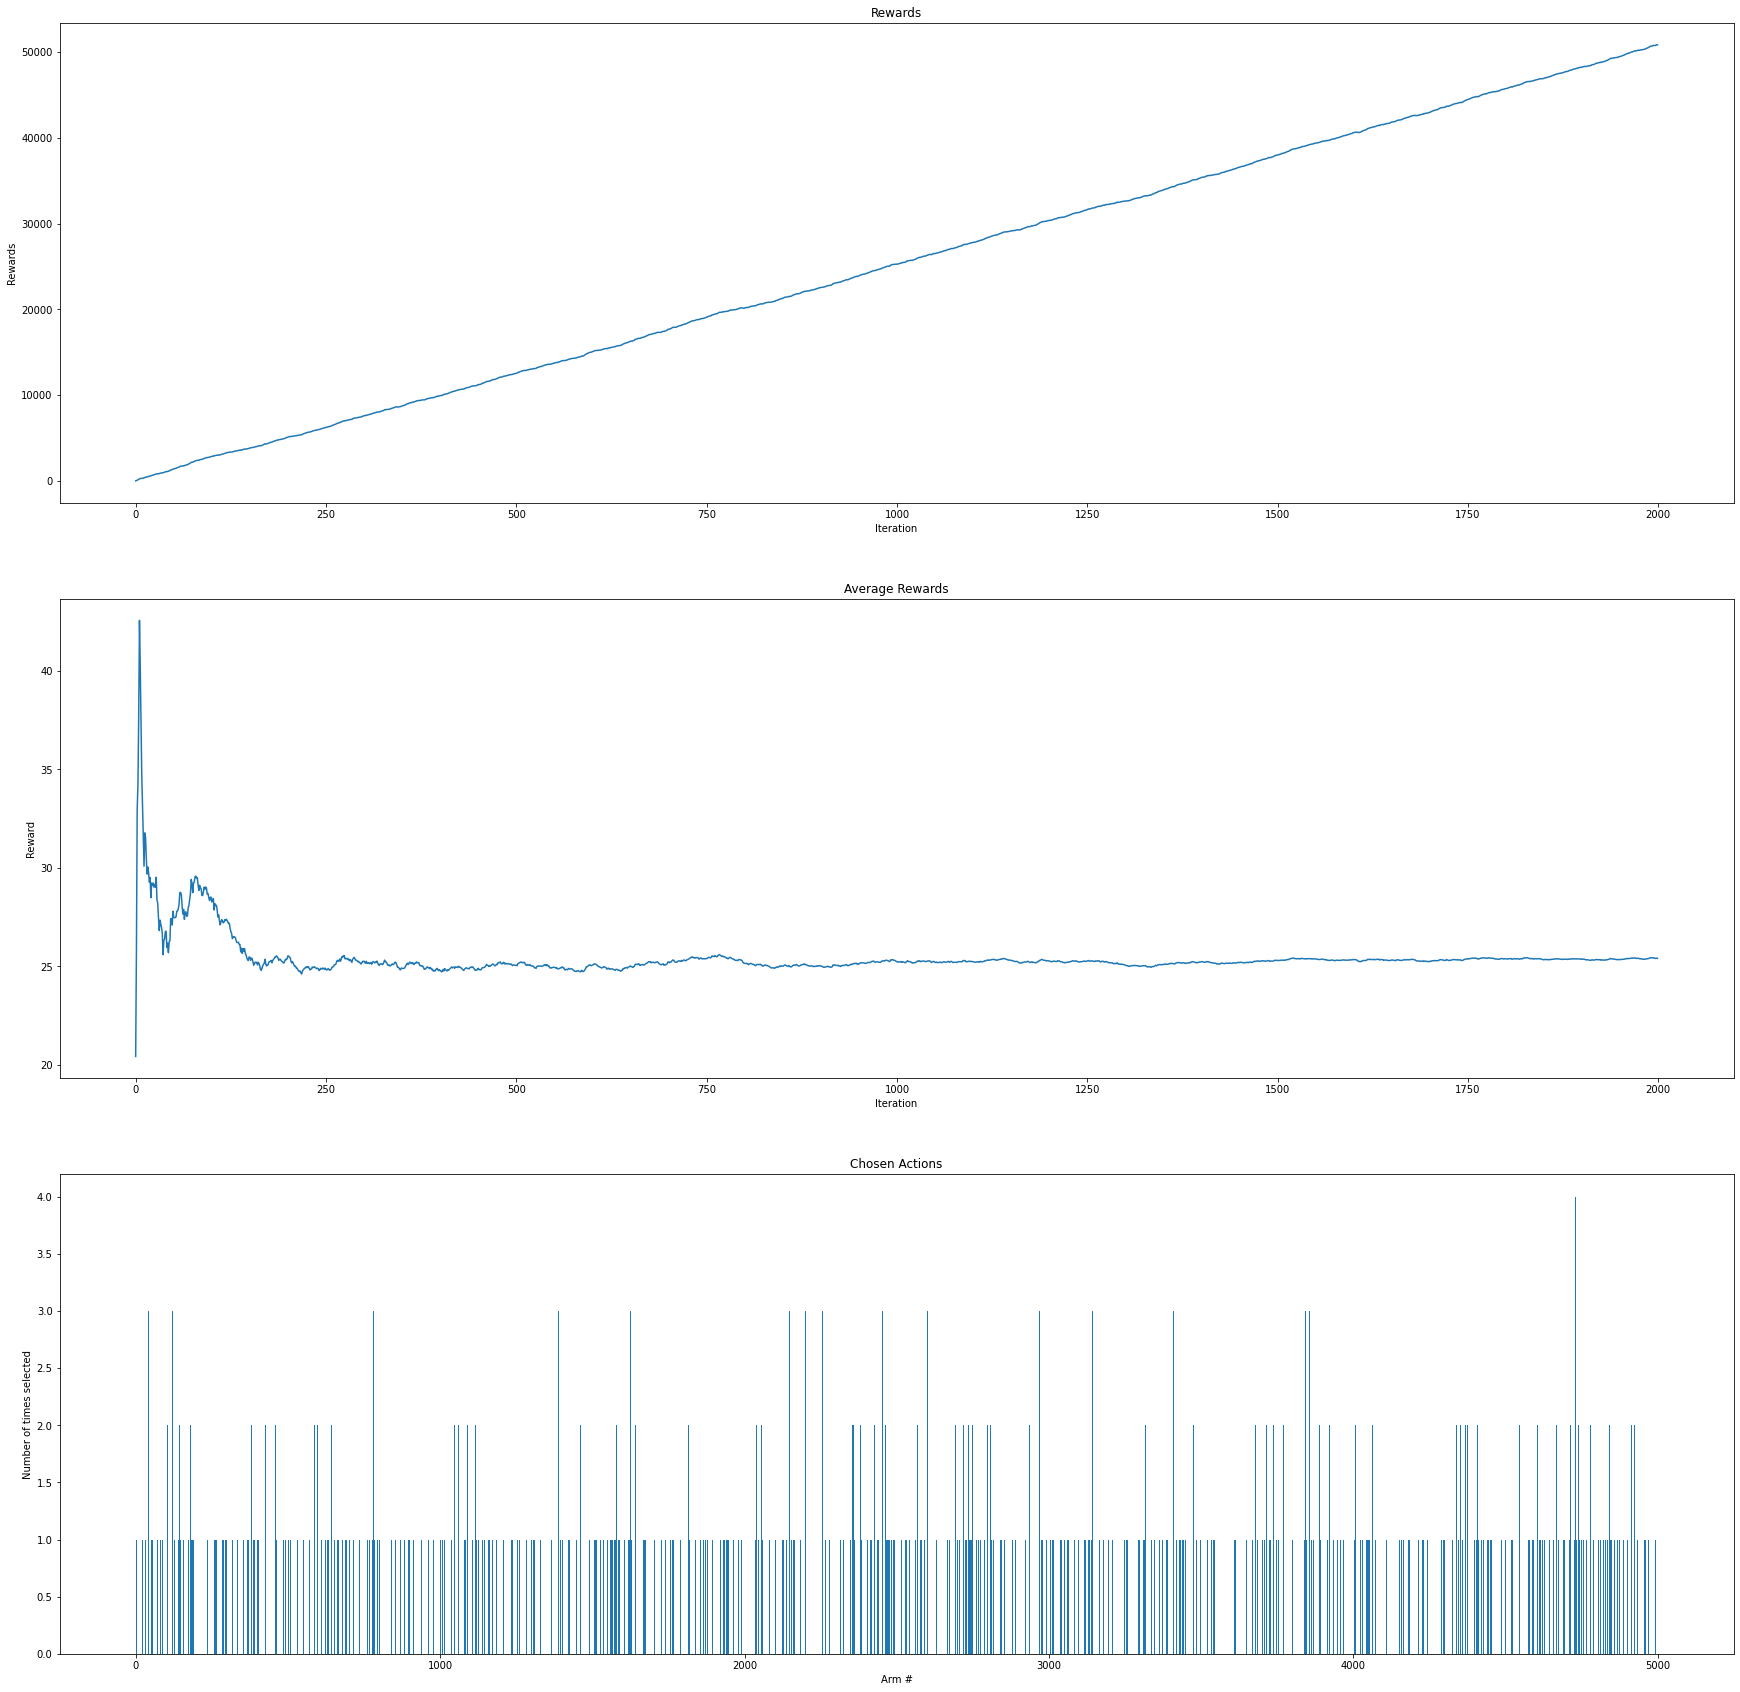

In [669]:
plot_history(RA_history)

# Clearly here arms are chosen at random signified by the bars of equal heights and a relatively low average reward

# Thompson Sampling Agent

In [670]:
def draw_distributions(T, env, idx):
    for i in range(env.k):
        samps = np.random.normal(T.post_mu[i], T.post_sigma[i], 10000)
        sns.kdeplot(samps, shade=True)
    plt.title('Iteration %s'%(idx+1), fontsize=20)
#     plt.legend(['mu=%s'%(env.rewards[i]) for i in range(env.k)], fontsize=16)
    plt.xlim(-10,10)
#     plt.ylim(0, 0.7)
    plt.xlabel('Average Satisfacton', fontsize=20)
    plt.ylabel('Density', fontsize=20)
    
    plt.show()

In [671]:
class ThompsonSamplingAgent():
    def __init__(self, env):
        self.env = env
        
        self.prior_mu = np.zeros(self.env.k)
        self.prior_sigma = np.full(self.env.k, 1000.0)
        
        self.post_mu = np.zeros(self.env.k)
        self.post_sigma = np.full(self.env.k, 1000.0)
        
        self.n = np.zeros(env.k)
        self.sum_satisfaction = np.zeros(env.k)
        
    def get_mu_from_current_distribution(self, arm):
        return np.random.normal(self.post_mu[arm], self.post_sigma[arm])
    
    def update_current_distribution(self, arm):
        self.post_sigma[arm] = np.sqrt((1 / self.prior_sigma[arm]**2 + self.n[arm])**-1)        
        self.post_mu[arm] = (self.post_sigma[arm]**2) * (self.sum_satisfaction[arm])
        
#         self.post_sigma[arm] = np.sqrt((1 / self.prior_sigma[arm]**2 + self.n[arm] / self.env.deviations[arm]**2)**-1)
#         self.post_mu[arm] = (self.post_sigma[arm]**2) * ((self.prior_mu[arm] / self.prior_sigma[arm]**2) + (self.sum_satisfaction[arm] / self.env.deviations[arm]**2))


#     def act(self):
#         rewards = []
#         average_rewards = []
#         cumulative_rewards = []

#         for i in range(2000):
#             if environment.k <= 10 and (i < 10 or (i < 100 and (i+1) % 10 == 0) or ((i+1) % 100 == 0)):
#                 draw_distributions(T, environment, i)

#             #get a sample from each posterior
#             post_samps = [T.get_mu_from_current_distribution(i) for i in range(environment.k)]

#             #index of distribution with highest satisfaction
#             chosen_idx = post_samps.index(max(post_samps))

#             #get a new sample from that distribution
#             s = T.env.choose_arm(chosen_idx)
#             T.n[chosen_idx] += 1
#             T.sum_satisfaction[chosen_idx] += s

#             #update other values
#             rewards.append(s)
#             average_rewards.append(sum(rewards)/len(rewards))
#             cumulative_rewards.append(sum(rewards))

#             #update that distributions posterior
#             T.update_current_distribution(chosen_idx)
            
#         return {"arms" : self.n, "rewards": rewards, "average_rewards": average_rewards,
#                "cumulative_rewards": cumulative_rewards}

In [672]:
T = ThompsonSamplingAgent(environment)

rewards = []
average_rewards = []
cumulative_rewards = []

for i in range(2000):
#     if environment.k <= 10 and (i < 10 or (i < 100 and (i+1) % 10 == 0) or ((i+1) % 100 == 0)):
#         draw_distributions(T, environment, i)

    #get a sample from each posterior
    post_samps = [T.get_mu_from_current_distribution(i) for i in range(environment.k)]

    #index of distribution with highest satisfaction
    chosen_idx = post_samps.index(max(post_samps))

    #get a new sample from that distribution
    s = T.env.choose_arm(chosen_idx)
    T.n[chosen_idx] += 1
    T.sum_satisfaction[chosen_idx] += s

    #update other values
    rewards.append(s)
    average_rewards.append(sum(rewards)/len(rewards))
    cumulative_rewards.append(sum(rewards))

    #update that distributions posterior
    T.update_current_distribution(chosen_idx)
    
TS_history = {"arms" : T.n, "rewards": rewards, "average_rewards": average_rewards,
                "cumulative_rewards": cumulative_rewards}

In [673]:
print(f"TOTAL REWARD : {sum(TS_history['rewards'])}")

TOTAL REWARD : 49995.61908679909


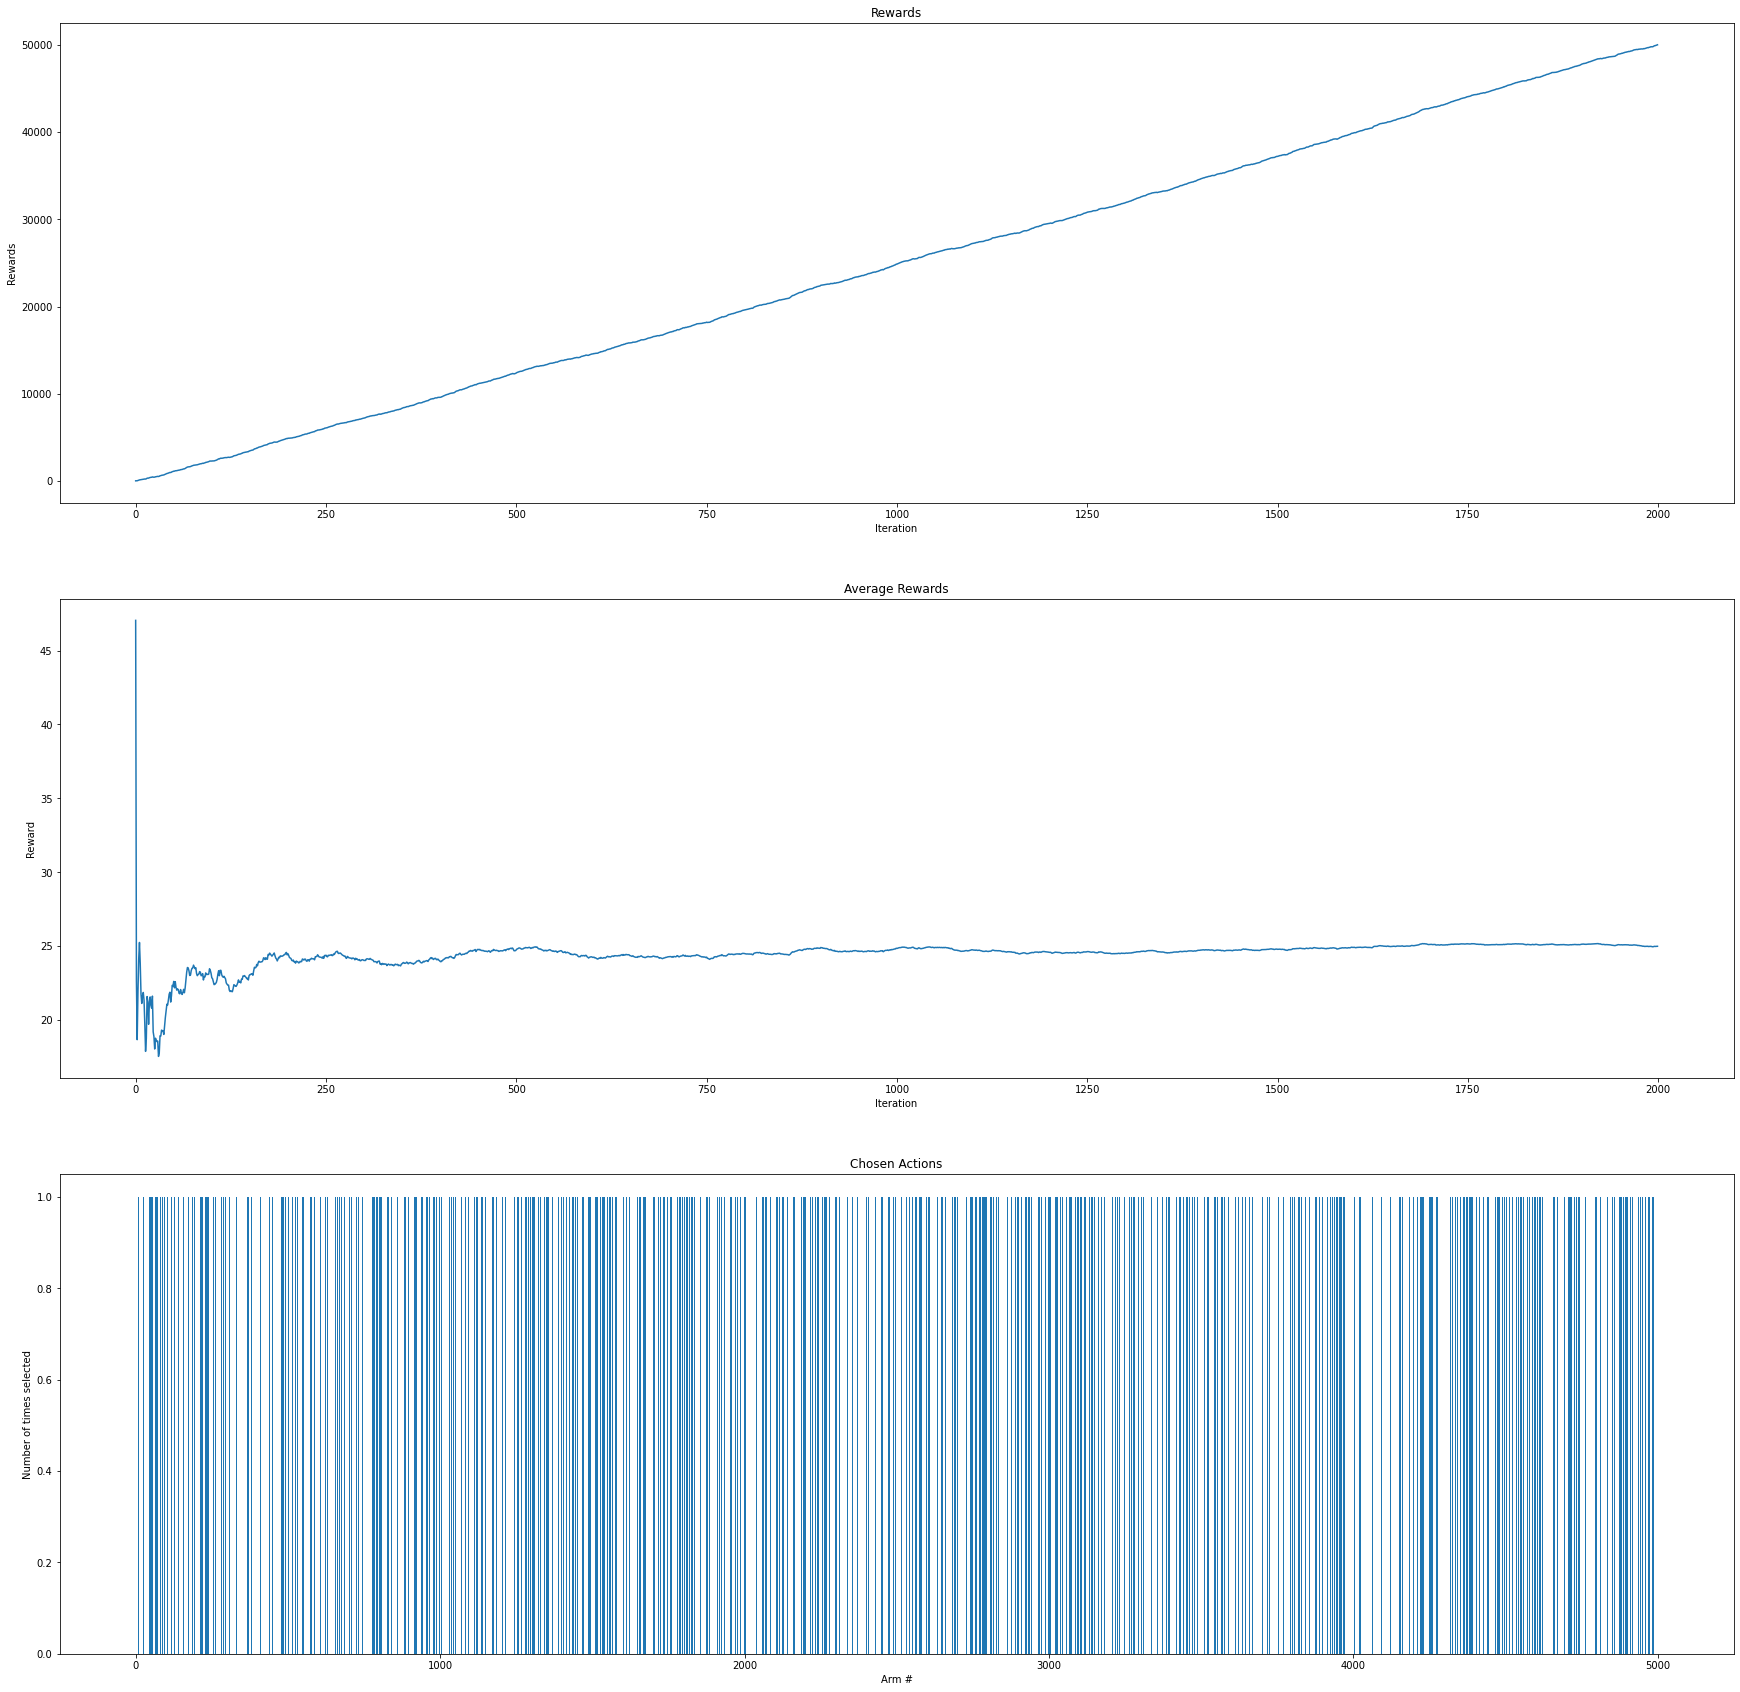

In [674]:
plot_history(TS_history)

# Epsilon Greedy Agent

In [675]:
class EpsilonGreedyAgent():
    def __init__(self, env, max_iterations=2000, epsilon=0.1):
        self.env = env
        self.iterations = max_iterations
        self.epsilon = epsilon

    def act(self):
        q_values = np.zeros(self.env.k)
        arm_rewards = np.zeros(self.env.k)
        arm_counts = np.zeros(self.env.k)

        rewards = []
        average_rewards = []
        cumulative_rewards = []

        for i in range(1, self.iterations + 1):
            arm = np.random.randint(self.env.k) if np.random.random() < self.epsilon else np.argmax(q_values)
            reward = self.env.choose_arm(arm)

            arm_rewards[arm] += reward
            arm_counts[arm] += 1
            q_values[arm] = arm_rewards[arm]/arm_counts[arm]

            cumulative_rewards.append(sum(rewards))
            rewards.append(reward)
            average_rewards.append(sum(rewards)/len(rewards))

        return {"arms" : arm_counts, "rewards": rewards, "average_rewards": average_rewards,
               "cumulative_rewards": cumulative_rewards}

In [676]:
epsilon_greedy_agent = EpsilonGreedyAgent(env=environment, max_iterations=2000, epsilon=0.1)
EG_history = epsilon_greedy_agent.act()
print(f"TOTAL REWARD : {sum(EG_history['rewards'])}")

TOTAL REWARD : 90660.40760739581


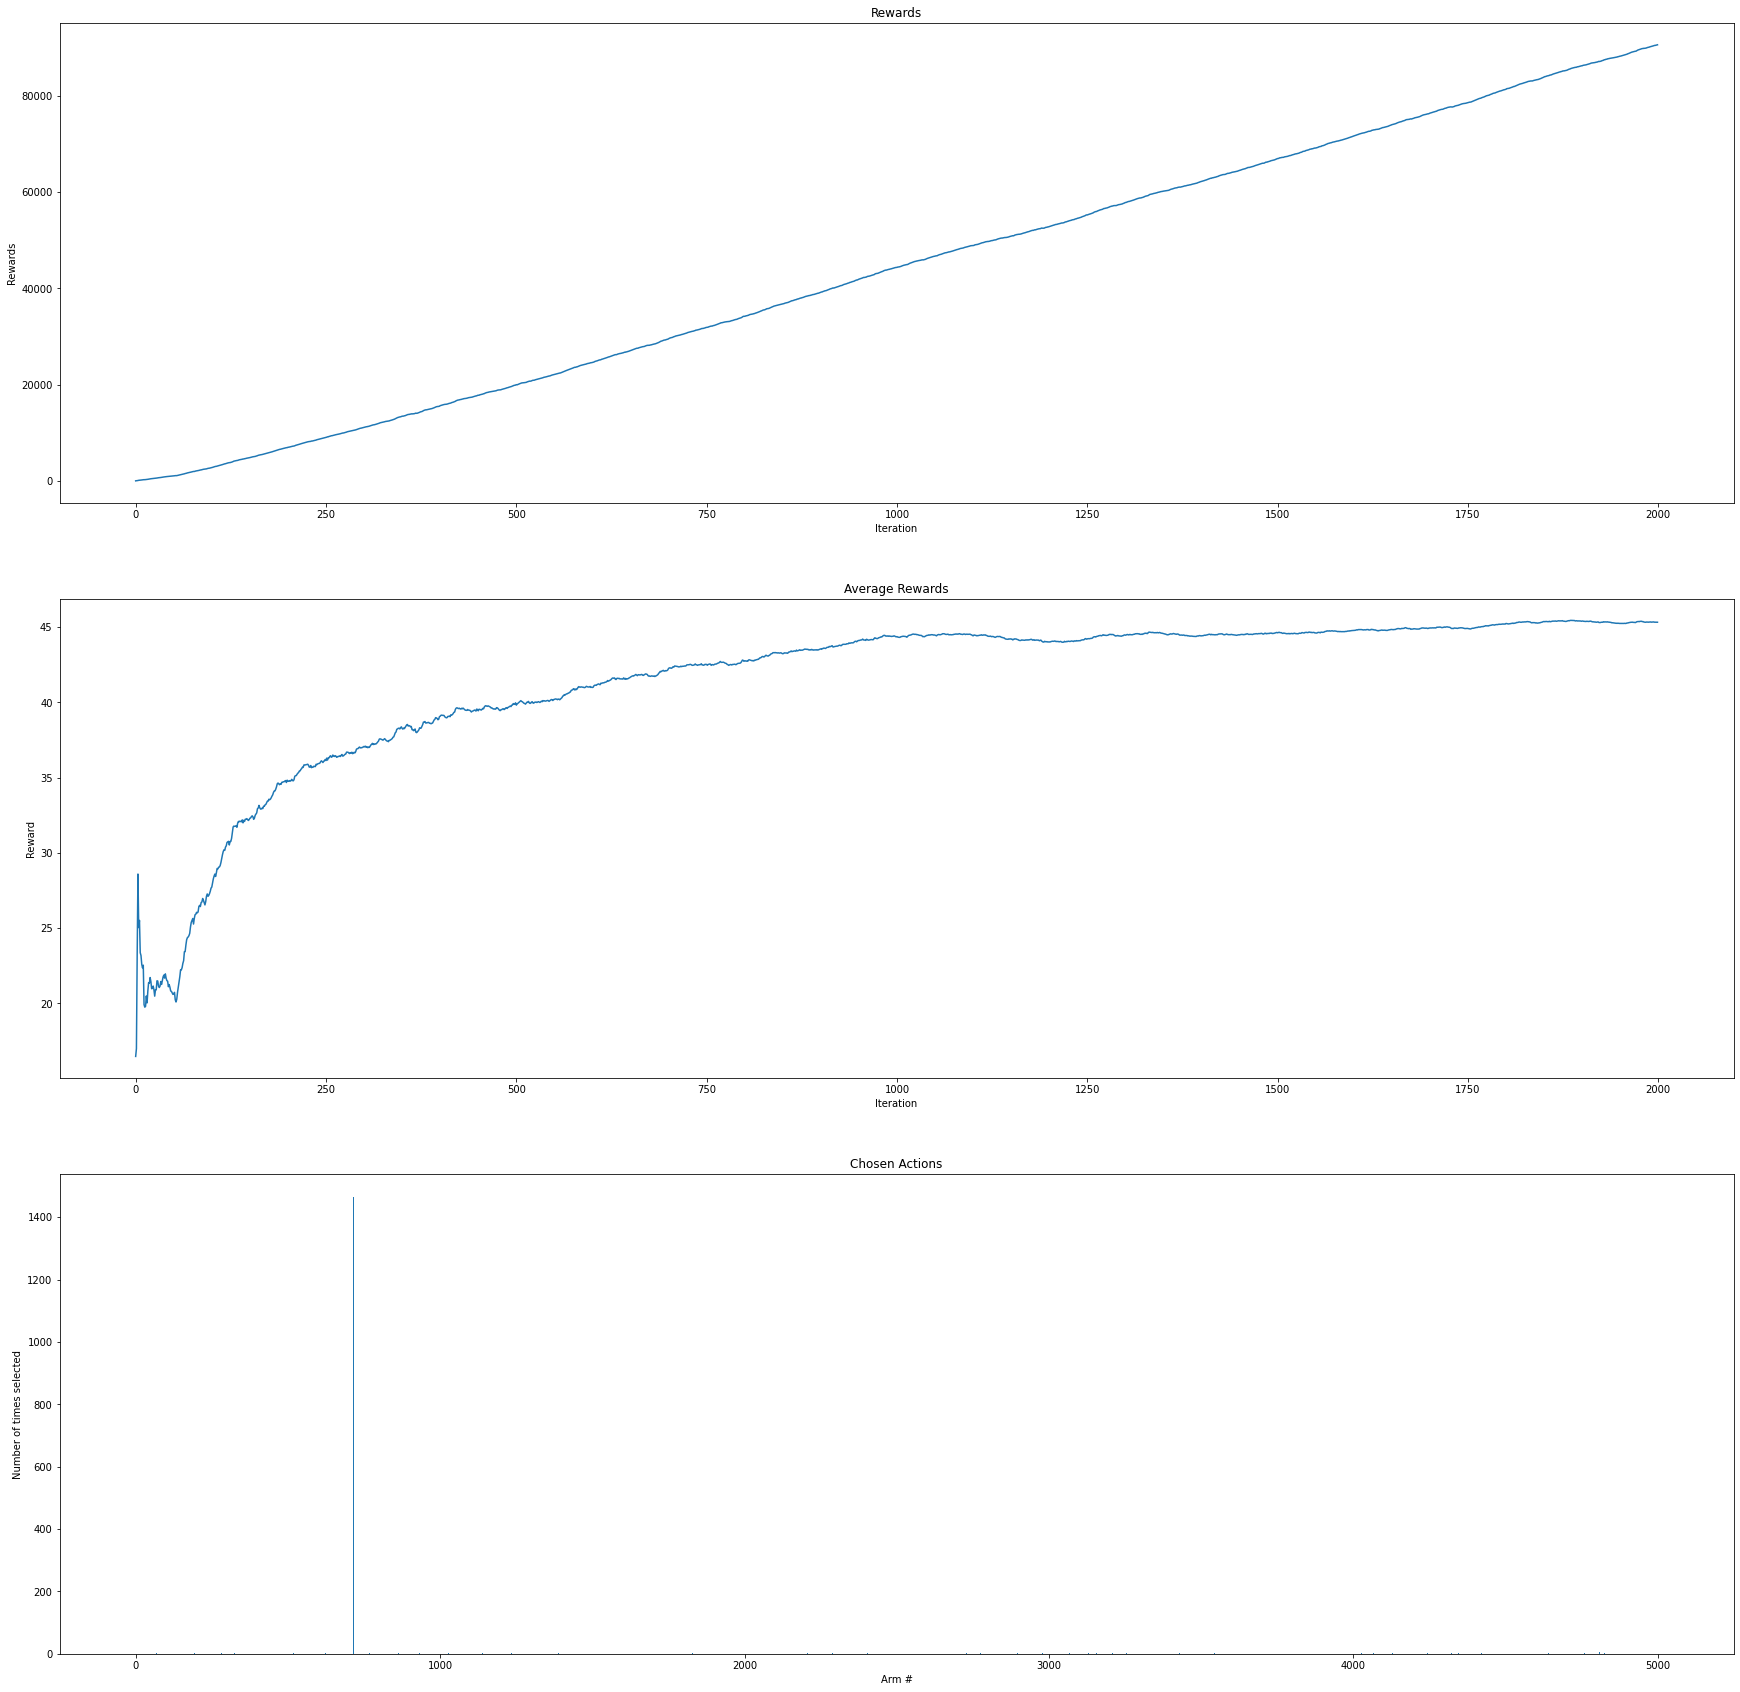

In [677]:
plot_history(EG_history)

# Upper Confidence Bound (UCB) Agent

In [678]:
class UpperConfidenceBoundAgent():
    def __init__(self, env, max_iterations=2000):
        self.env = env
        self.iterations = max_iterations
  
    def act(self):
        q_values = np.zeros(self.env.k)
        arm_rewards = np.zeros(self.env.k)
        arm_counts = np.zeros(self.env.k)

        rewards = []
        average_rewards = []
        cumulative_rewards = []

        #traverse every arm once
        for arm in range(self.env.k):
            reward = self.env.choose_arm(arm)

            arm_rewards[arm] += reward
            arm_counts[arm] += 1
            q_values[arm] = arm_rewards[arm]/arm_counts[arm]

        for i in range(1, self.iterations + 1):
            # arm = np.random.choice(self.env.k) if np.random.random() < self.epsilon else np.argmax(q_values)
            arm = 0
            cur = 0
            # finds action where quantity u + hoffdings-constant is maximized
            for a in range(self.env.k):
                UCB = q_values[a] + np.sqrt((2*np.log(i))/arm_counts[a])
                if UCB > cur:
                    cur = UCB
                    arm = a

            reward = self.env.choose_arm(arm)

            arm_rewards[arm] += reward
            arm_counts[arm] += 1
            q_values[arm] = arm_rewards[arm]/arm_counts[arm]

            cumulative_rewards.append(sum(rewards))
            rewards.append(reward)
            average_rewards.append(sum(rewards)/len(rewards))

        return {"arms" : arm_counts, "rewards": rewards, "average_rewards": average_rewards,
               "cumulative_rewards": cumulative_rewards}

In [679]:
UCB_agent = UpperConfidenceBoundAgent(env=environment, max_iterations=2000)
UCB_history = UCB_agent.act()
print(f"TOTAL REWARD : {sum(UCB_history['rewards'])}")

TOTAL REWARD : 87698.22954939646


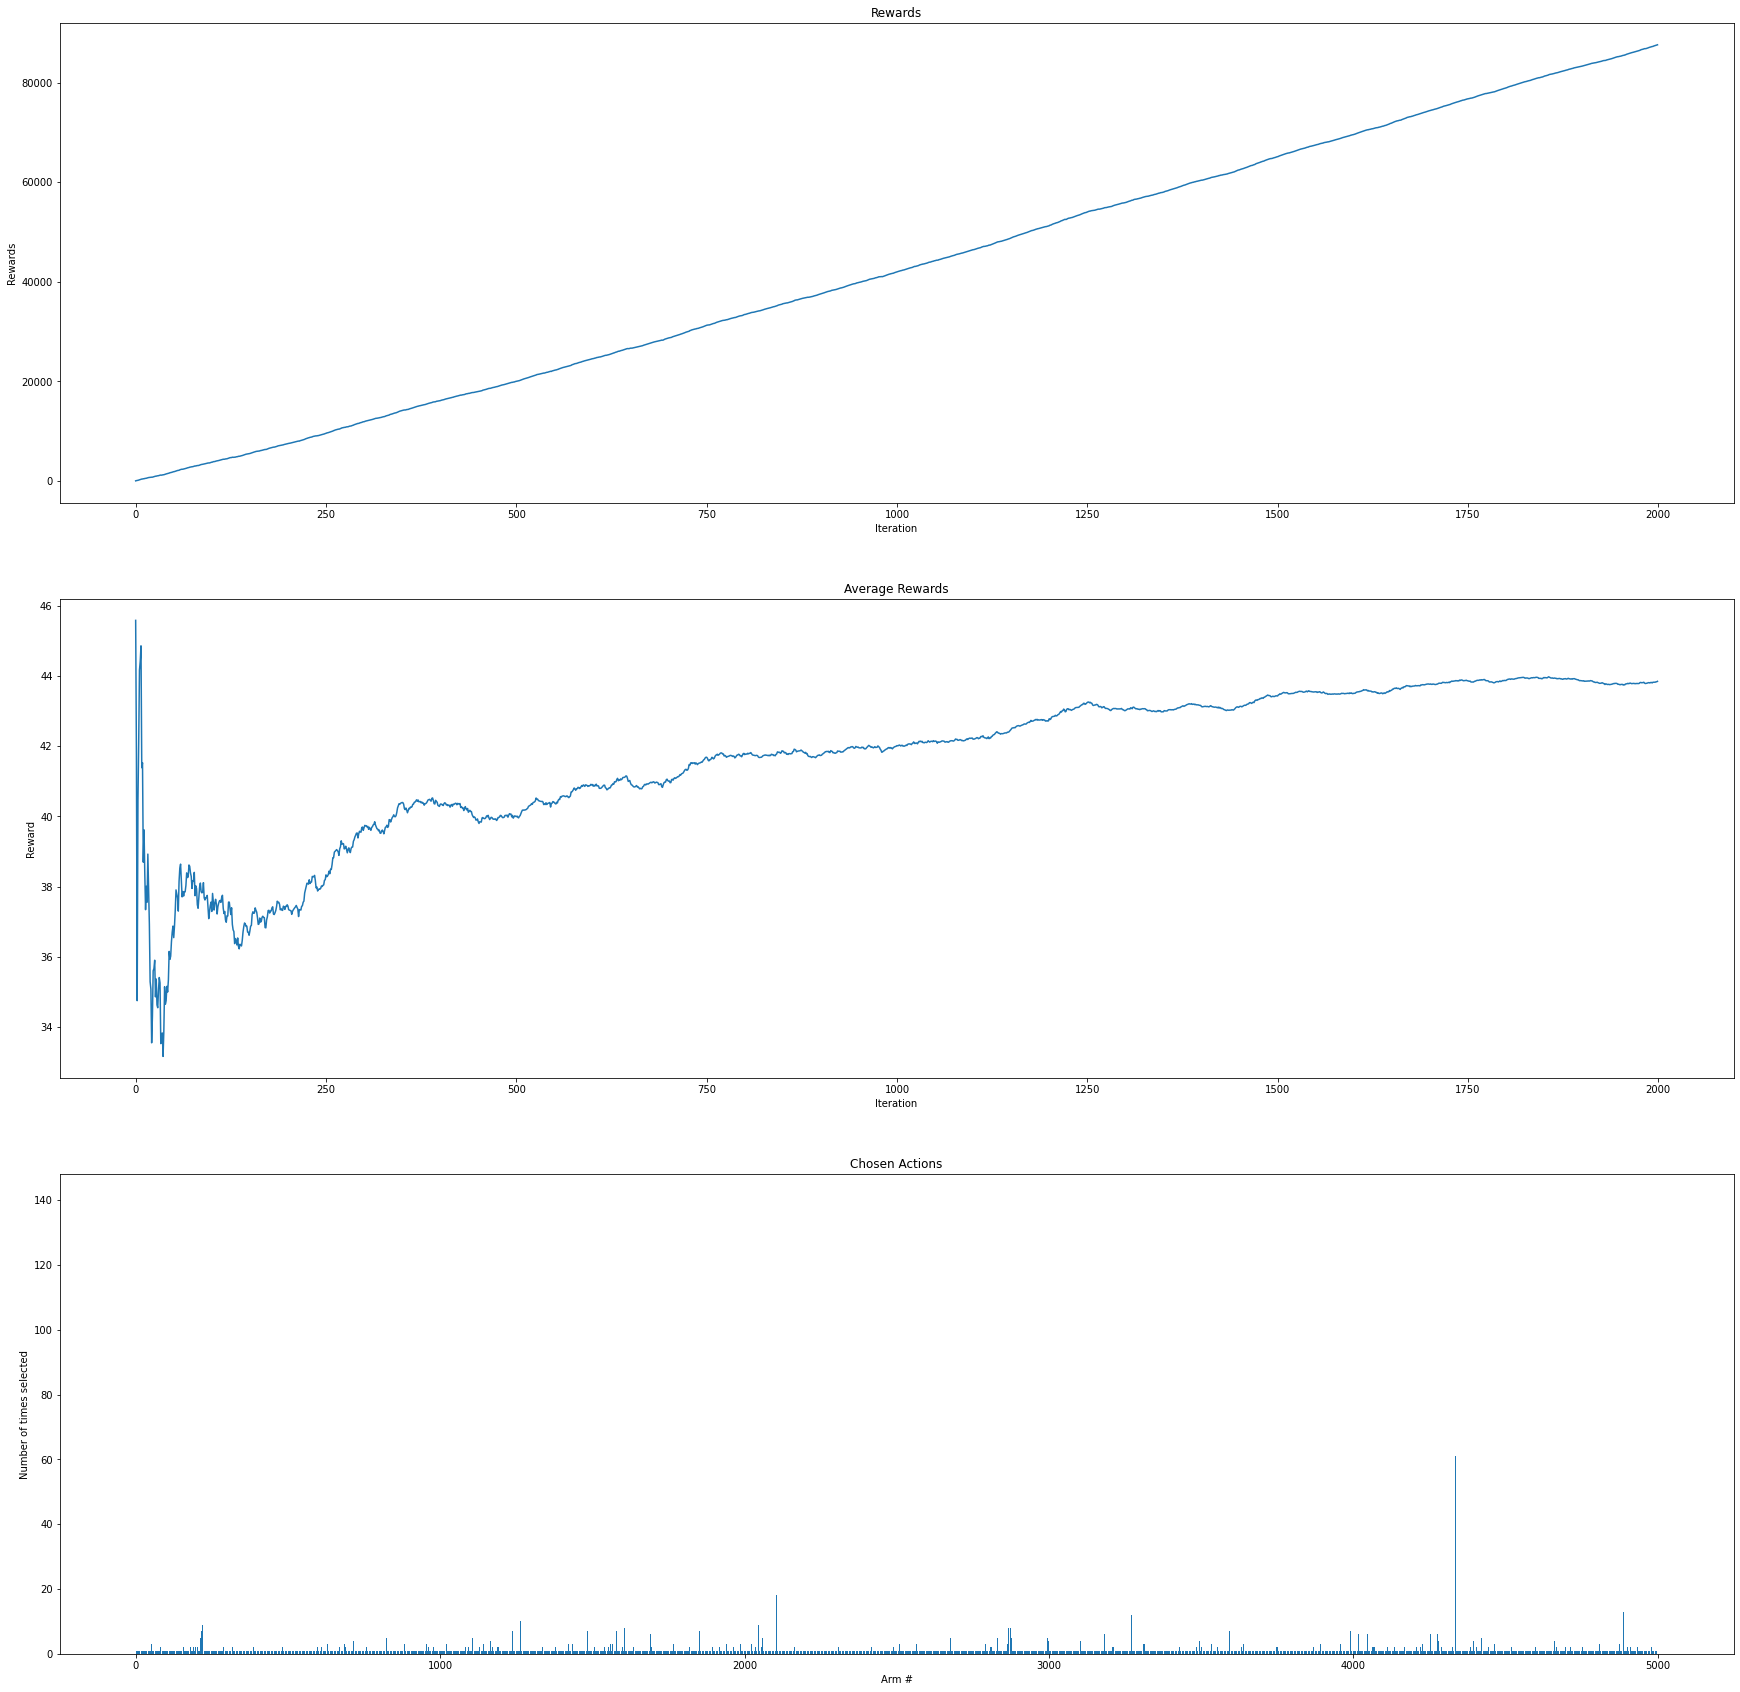

In [680]:
plot_history(UCB_history)

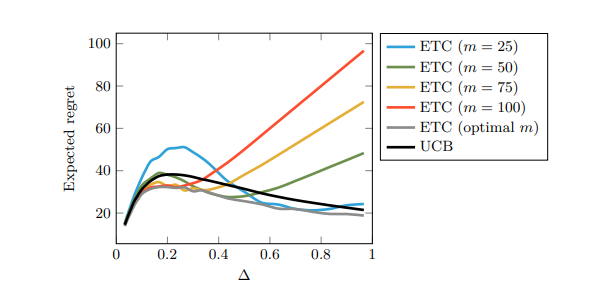

## Understanding this graph fully
In this graph, the x-axis (delta) represents the sub-optimality gap, or the gap between arm #2's reward and the optimal reward. This is graphed against the y-axis of regret. It makes sense that regret is very small when delta is small as the gap between the 2 arms is so little that it doesn't matter which arm the algorithm picks. However, as delta increases, the arm the algorithm chooses becomes more important thus leading to an increase in regret. But, after peaking, the regret begins to dip down again. I believe this is because the gap between optimal and suboptimal is getting so large that it is increasingly noticable for the algorithm to make adjustments in fewer trials leading to less and less regret. Also, the graph shows how the rate of regret varies for the size of m (or number of rounds chosen to explore) compared to the UCB method.

# UCB Pick and Compare Method

In [681]:
class UCB_PickAndCompareAgent():
    def __init__(self, env, max_iterations=2000):
        self.env = env
        self.iterations = max_iterations
  
    def act(self):
        q_values = np.zeros(self.env.k)
        arm_rewards = np.zeros(self.env.k)
        arm_counts = np.zeros(self.env.k)

        rewards = []
        average_rewards = []
        cumulative_rewards = []

        #traverse every arm once
        for arm in range(self.env.k):
            reward = self.env.choose_arm(arm)

            arm_rewards[arm] += reward
            arm_counts[arm] += 1
            q_values[arm] = arm_rewards[arm]/arm_counts[arm]

        # set default value for previous arm
        previous_arm = 0
        for i in range(1, self.iterations + 1):
            
            UCB_previous = q_values[previous_arm] + np.sqrt((2*np.log(i))/arm_counts[previous_arm])
            
            compare_arm = np.random.choice(self.env.k)
            UCB_compare = q_values[compare_arm] + np.sqrt((2*np.log(i))/arm_counts[compare_arm])

            arm = (UCB_previous > UCB_compare if previous_arm else compare_arm)
    
            reward = self.env.choose_arm(arm)

            arm_rewards[arm] += reward
            arm_counts[arm] += 1
            q_values[arm] = arm_rewards[arm]/arm_counts[arm]

            cumulative_rewards.append(sum(rewards))
            rewards.append(reward)
            average_rewards.append(sum(rewards)/len(rewards))

        return {"arms" : arm_counts, "rewards": rewards, "average_rewards": average_rewards,
               "cumulative_rewards": cumulative_rewards}

In [682]:
UCB_PC_agent = UCB_PickAndCompareAgent(env=environment, max_iterations=2000)
UCB_PC_history = UCB_PC_agent.act()
print(f"TOTAL REWARD : {sum(UCB_PC_history['rewards'])}")

TOTAL REWARD : 50332.72329473538


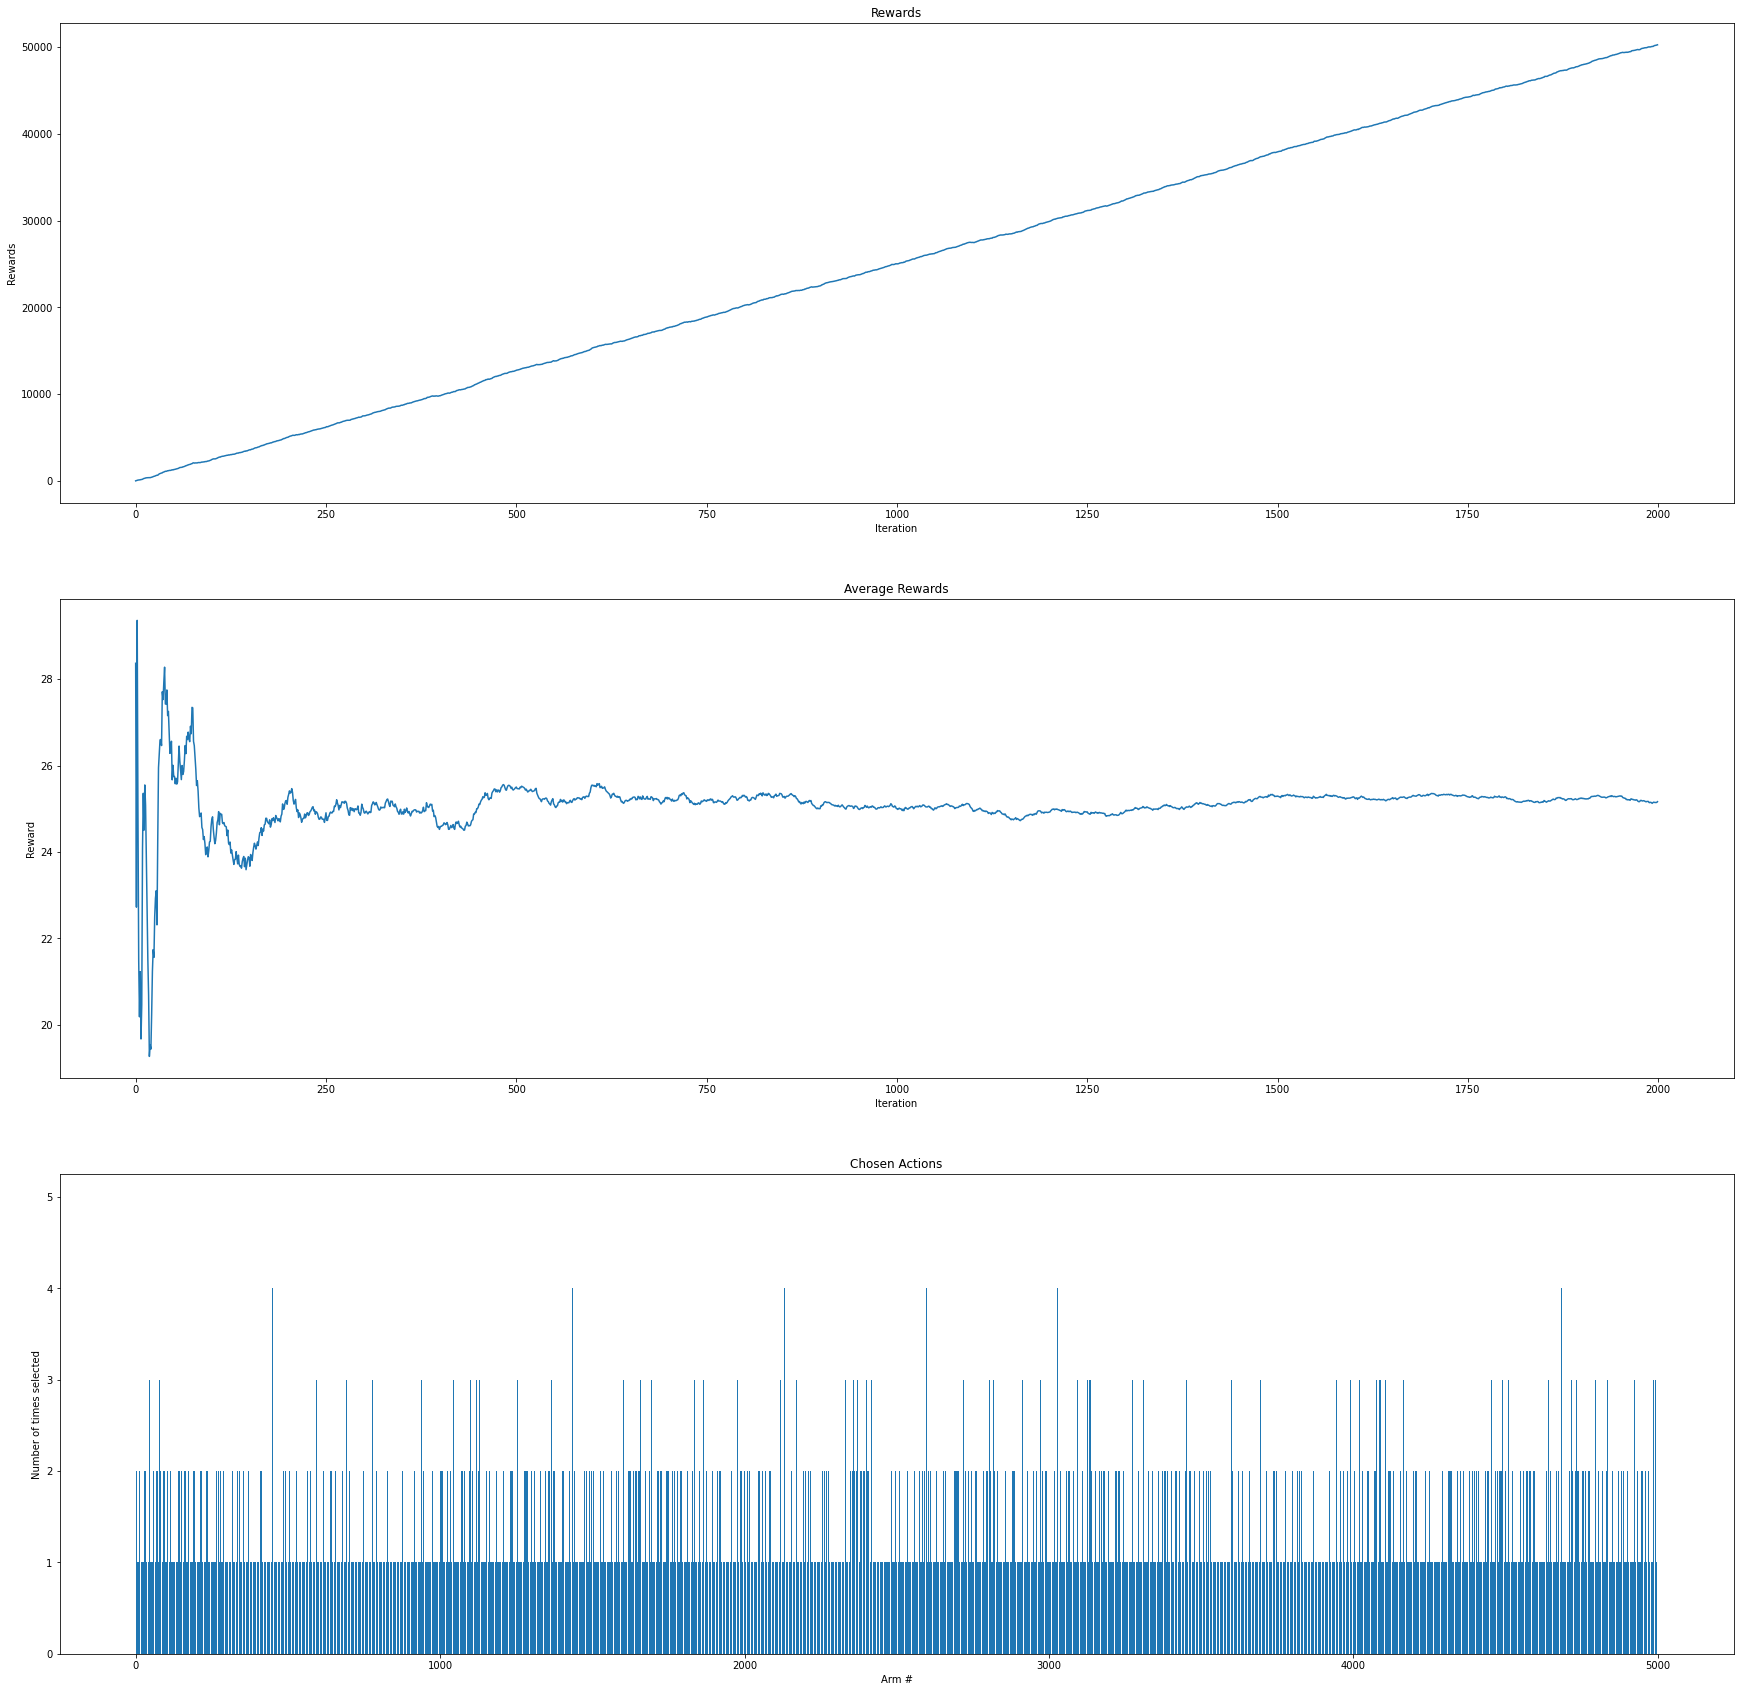

In [683]:
plot_history(UCB_PC_history)